CS4287 Project 1

Name : Szymon Szulc   ID1 : 21323208
Name : Boris Bobylkov ID2 : 21317097

This code executes to the end without error.

Sources:
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
https://www.tensorflow.org/api_docs/python/tf/keras/Model
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten
https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html
https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate


In [106]:
# Importing Libraries 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [107]:
# Load dataset : tf.keras.dataset.mnist
# MNIST data set contains 60,000 28x28 black & white images of digits (0-9) + 10,000 images for test set.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizing Data : images have pixel values in range [0, 255].
# Dynamic range of images [0,255], by /255 we change the range to [0,1].

# We normalize data 
x_train = x_train / 255.0
x_test = x_test / 255.0

# Why do we normalize the dataset? We do this to reduce the dominance of big values over small values, this normalization causes our accuracy to increase while also reducing execution time.

# We are adding a channel layer here, which allows model to deal with image data.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Check data type : ensure data is correct format before training.
dataType = x_train.dtype
print(f"Data type: {dataType}")
labelType = y_test.dtype
print(f"Data type: {labelType}")

Data type: float64
Data type: uint8


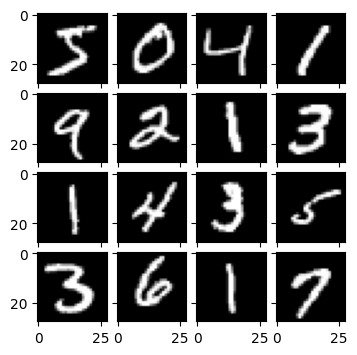

In [108]:
# Data visualization : Display 16 images from training set for visual confirmation of data.
# Imports used in this section: matplotlib.pyplot as plt & mpl_toolkits.axes_grid1 import ImageGrid 
im_list = []  # Empty list to store sample images.
n_samples_to_show = 16  # Number of images to display (4x4 grid)
for i in range(n_samples_to_show):
    im_list.append(x_train[i])  # This appends the first 16 used to visually confirm data.

# Visualization
# Setting up 4x4 grid to visualize images.
fig = plt.figure(figsize=(4, 4))  # setting figure size.

# Ref https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html

grid = ImageGrid(fig, 111,  # similar to subplot(111), used ImageGrid for custom layout.
                 nrows_ncols=(4, 4),  # 4row x 4col grid
                 axes_pad=0.1,  # padding between grid.
                 )

# Display image grid.
for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, 'gray')  #show each image in grayscale
plt.show()  # Show entire grid.


In [109]:
# Model Build
# Building Multi-Layer Perceptron using Keras.
# This model classifies digits (0-9), output = 10 classes.
NUM_CLASSES = 10  # num of classes (0-9)

# Here we define a Sequential model that processes data layer by layer.
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
model = tf.keras.Sequential([

    # Input Layer : Explicitly define the input shape as (28, 28).
    # Flatten the 28x28 images into 1D vector, as Dense layers expect 1D vector as input.

    tf.keras.Input(shape=(28, 28, 1)),  # Input layer as shape 28x28.
    tf.keras.layers.Flatten(),
    # Creating a flat vector, disregarding locality of features,Representing image as vector.
    tf.keras.layers.Dense(256, activation='relu'),
    # Feeding vector to dense layer, with activation ReLU with 256 neurons.
    tf.keras.layers.Dense(256, activation='softmax'),
    # Feeding it through a different hidden layer with 256 neurons.
    
    # ReLU: non-linear activation function with the conditions:
    # For all x > 0, the function is a straight line y = x.
    # For all x =< 0, the function outputs a flat line at y=0.
    # This prevents negative inputs from firing negative values. This helps mitigate the vanishing gradient problem - which can cause weighted parameters to update very slowly, or not at all.

    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    # Outputs NUM_CLASSES ( number of classes) with sigmoid activation.

    # Sigmoid : squashes output to probability between 0 & 1 for each class. We initially went sigmoid before we found out softmax was better for MNIST dataset.
    # Softmax : Probability distribution over multiple classes : [ 2.0, 1.0, 0.1 ] where [e^2, e^1, e^{0.1}] = [7.39, 2.71, 1.11]. Now we divide by the sum of these, so : 7.39 + 2.71 + 1.11 = 11.21, 
    # [7.39/11.21, 2.71/11.21, 1.11/11.21] = [0.66, 0.24, 0.1], where the first class has 66% probability, next has 24% & last has 10%. The class with the highest probability is chosen (so 66%). The reason why we chose softmax was because sigmoid predicts for each class, while softmax predicts probability over multiple classes, where the sum of these probabilities must = 1.
])

# Compiling model with high-level keras
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
model.compile(optimizer='adam',
              # using adam optimizer - used to adjust learning rate dynamically.
              # adam is not very dependent on hyper values.

              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),

              # Loss : SparseCategoricalCrossentropy is used here as we are dealing with integer labels (0-9)

              # Evaluate model via accuracy

              metrics=['accuracy'])



# We clone the model here so that when k-fold cross val does not train on already trained model.
model_cloned = tf.keras.models.clone_model(model)



# Model training - using data (x_train, y_train) for 30 epochs.
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# Assigned model.fit() to history variable to plot on graph in next step.
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), verbose=1)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5998 - loss: 1.7253 - val_accuracy: 0.7002 - val_loss: 0.8415
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7016 - loss: 0.7637 - val_accuracy: 0.7031 - val_loss: 0.6229
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7098 - loss: 0.5951 - val_accuracy: 0.7250 - val_loss: 0.5682
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7511 - loss: 0.5286 - val_accuracy: 0.8393 - val_loss: 0.4655
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8831 - loss: 0.3829 - val_accuracy: 0.9684 - val_loss: 0.2044
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9797 - loss: 0.1492 - val_accuracy: 0.9713 - val_loss: 0.1475
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9856 - loss: 0.0932 - val_accuracy: 0.9743 - val_loss: 0.1229
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9889 - loss: 0.0668 - 

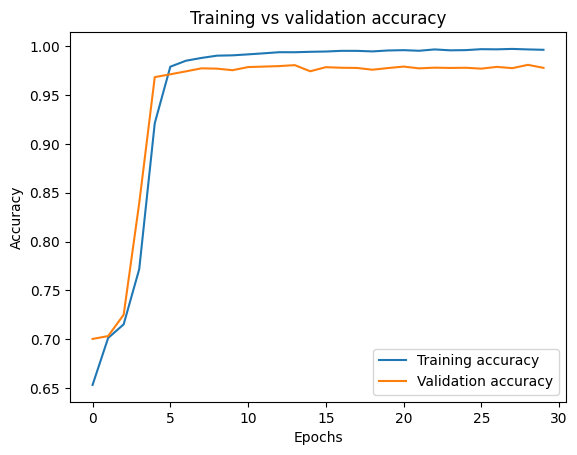

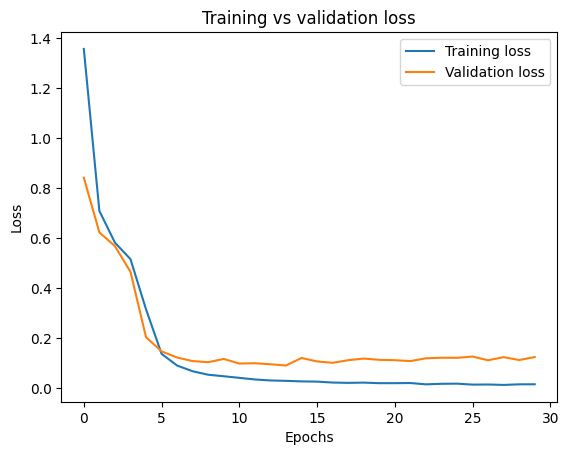

In [110]:
#Plotting Training vs Validation accuracy & Training vs validation loss. We do this to check if our model is overfitting.
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs validation accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs validation loss')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


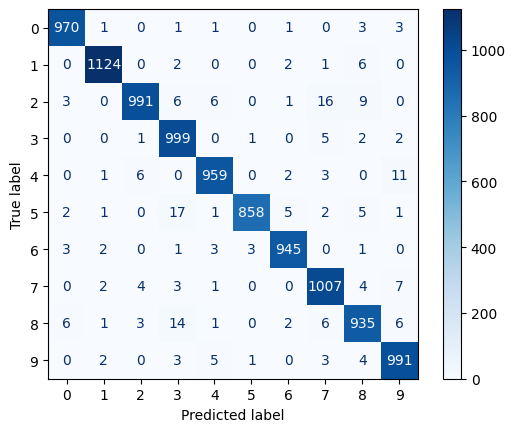

In [111]:
# Confusion Matrix 
# This class is responsible for converting history tensorflow so that we can work with it.
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model,["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

y_pred = classifier.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
# Plotting confusion matrix below:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap="Blues")
plt.show()

In [112]:
# K-Fold Cross Validation

# We are using sgd activation function because it is more dependent on hyperparameters which will affect the final accuracy of this model.
model_cloned.compile(optimizer='sgd', 

              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),

              metrics=['accuracy'])

# Instead of training dataset a single time, we split the dataset into K number of folds. It used different fold for validation set and K-1 for training set. This ensures that the model is evaluated on every data point as part of validation set. This ensures that we get the most of our dataset by using it for validation and testing.

# Here we create a KFold object and define number of folds, in our case 5 equal sub-sets.
kf = KFold(n_splits=5)

all_histories = []

# kf.split(x_train) : return indices to split the data into train and validation sets of each fold.
for train_index, val_index in kf.split(x_train):
    # train_index contains indices for training set for this fold.
    # val_index contains indices for validation set for this fold.

    # Split data using indices for current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]  # Training and validation inputs
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]  # Training and validation labels

    # Train model for this fold
    # Model is trained on x_train_fold & evaluated on x_val_fold.
    history = model_cloned.fit(x_train_fold, y_train_fold, epochs=30, validation_data=(x_val_fold, y_val_fold), verbose=0)
    all_histories.append(history.history)
    # Evaluate model on validation set 
    val_loss, val_acc = model_cloned.evaluate(x_val_fold, y_val_fold, verbose=0)

    # Print validation accuracy for current fold.
    print(f"Validation accuracy for this fold : {val_acc * 100:.2f}%")


    

Validation accuracy for this fold : 32.24%
Validation accuracy for this fold : 49.47%
Validation accuracy for this fold : 63.42%
Validation accuracy for this fold : 66.89%
Validation accuracy for this fold : 70.15%


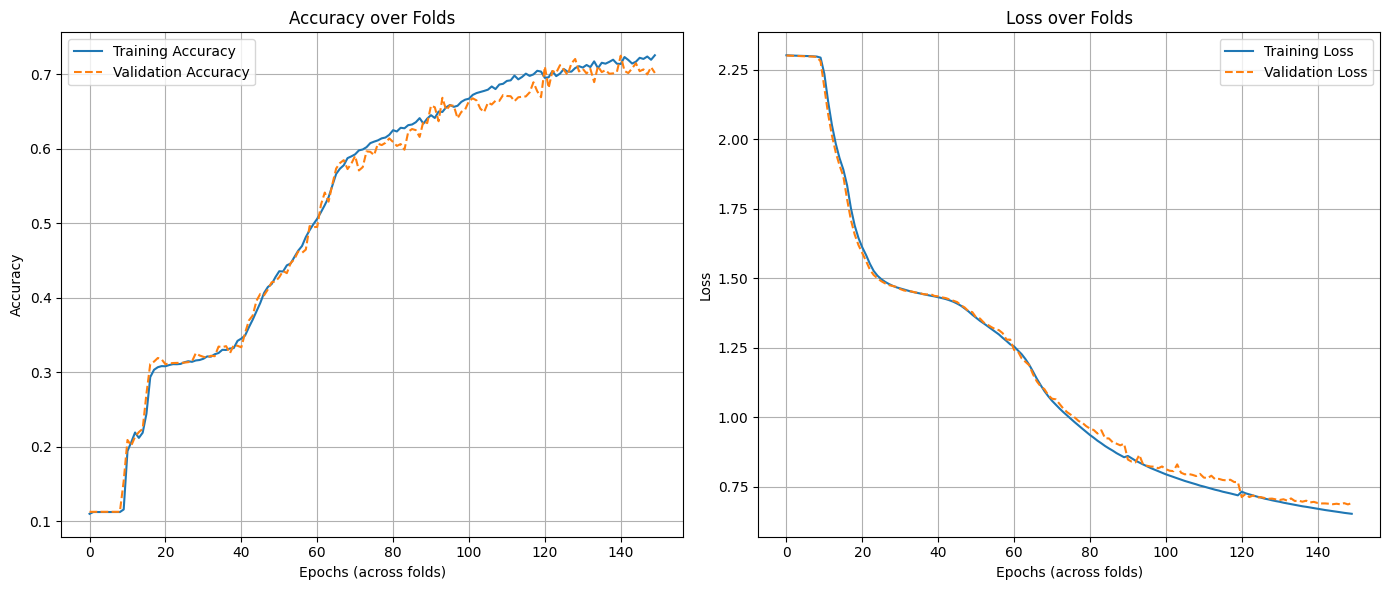

In [113]:
# Initialize lists to accumulate metrics across all folds
all_train_accuracies = []
all_val_accuracies = []
all_train_losses = []
all_val_losses = []

# Iterate through all fold histories to accumulate the metrics
for history in all_histories:
    all_train_accuracies.extend(history['accuracy'])
    all_val_accuracies.extend(history['val_accuracy'])
    all_train_losses.extend(history['loss'])
    all_val_losses.extend(history['val_loss'])

# Create plots for accuracy and loss
plt.figure(figsize=(14, 6))

# Plotting accuracy & Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(all_train_accuracies, label='Training Accuracy')
plt.plot(all_val_accuracies, label='Validation Accuracy', linestyle='dashed')
plt.title('Accuracy over Folds')
plt.xlabel('Epochs (across folds)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(all_train_losses, label='Training Loss')
plt.plot(all_val_losses, label='Validation Loss', linestyle='dashed')
plt.title('Loss over Folds')
plt.xlabel('Epochs (across folds)')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [114]:
# We are determining how well our first model would be able to perform.
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.96      0.97      1032
           3       0.96      0.99      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.96      0.98       892
           6       0.99      0.99      0.99       958
           7       0.97      0.98      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [115]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
# Evaluation function calculates loss and accuracy on test data.
eval_loss, eval_acc = model.evaluate(x_test, y_test, verbose=1)
# Print data in % format.
print('Eval accuracy percentage: {:.2f}'.format(eval_acc * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9757 - loss: 0.1377
Eval accuracy percentage: 97.79
